In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import collections
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [2]:
import xgboost as xgb

## Učitavanje podataka
- učitavanje
- odbacivanje stupaca koje ne koristimo u modelu

In [3]:
data = pd.read_csv("treca_faza.csv", parse_dates=[2,5,6,7])

In [4]:
data = data.drop(['Unnamed: 0','Unnamed: 0.1','STANJE_NA_KRAJU_PRETH_KVARTALA', 'STANJE_NA_KRAJU_KVARTALA', 'KLIJENT_ID'], axis = 1)
data = data.drop(['VRSTA_KLIJENTA', 'PROIZVOD', 'VALUTA'], axis = 1)
data = data.drop(['DATUM_ZATVARANJA','DATUM_IZVJESTAVANJA', 'OZNAKA_PARTIJE', 'DATUM_OTVARANJA', 'PLANIRANI_DATUM_ZATVARANJA', 'TIP_KAMATE'], axis = 1)
data = data.drop(['RATA'], axis = 1)

data['VRSTA_PROIZVODA'] = data.VRSTA_PROIZVODA.map({'A':0,'L':1})

In [5]:
data = data.drop(['KAMATA_KVADART','KAMATA_IZNOS'], axis = 1)

In [6]:
X = data.iloc[:, ~data.columns.isin(['PRIJEVREMENI_RASKID','EURO_OTV','EURO_ZATV','DOLAR_OTV','DOLAR_ZATV','FRANAK_OTV','FRANAK_ZATV','PRICE_INDEX_ZATV','AVG_PLACA_ZATV', 'GDP_ZATV', 'NEZAPOSLENOST_ZATV','BDP_ZATV'])] #data[best]
Y = data['PRIJEVREMENI_RASKID'].map({'N':0, 'Y':1})

X = X.sort_index(axis=1)

## Priprema test i train podataka

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

## Instanciranje XGB klasifikatora

In [8]:
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.5,
                max_depth = 8, alpha = 50, n_estimators = 60, seed = 42)

In [9]:
xg_reg.fit(X_train,y_train)

XGBClassifier(alpha=50, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

# Selecting best features

In [10]:
importances = xg_reg.get_booster().get_score(importance_type='gain')
sorted_x = sorted(importances.items(), key=lambda kv: kv[1], reverse=True)
most_C = collections.Counter(importances).most_common(25)
features = [x for x, _ in most_C]
num = [x for _, x in most_C]

In [11]:
features

['VRSTA_PROIZVODA',
 'POVIJEST_NEPRIJEVREMENIH',
 'TM0109',
 'POVIJEST_PRIJEVREMENIH',
 'FL0900',
 'ZATVARANJE',
 'KAMATA_B',
 'PRICE_INDEX_OTV',
 'KAMATA_C',
 'MJESECI',
 'GDP_OTV',
 'h',
 'OTVARANJE',
 'FL1100',
 'VALUTA_1',
 'FD0200',
 'KAMATA_A',
 'NADVRSTA',
 'VISINA_KAMATE',
 'AVG_PLACA_OTV',
 'FL1202',
 'FD0100',
 'NEZAPOSLENOST_OTV',
 'JEDNODNEVNI',
 'l']

In [12]:
print('Postotak varijabilnosti koji pokrivaju odabrane značajke: ', sum(num)/sum(importances.values()))

Postotak varijabilnosti koji pokrivaju odabrane značajke:  0.9482734555610509


# Cross - validation

In [13]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

X = X_train[features]
Y = y_train
X = X.sort_index(axis=1)
x = X.values
Y = np.ravel(Y)

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.7, learning_rate = 0.5,
                max_depth = 8, alpha = 50, n_estimators = 40)

accuracy_XGBoost = []
f1_XGBoost = []
predictions_XGBoost = []

cv = KFold(n_splits=5, shuffle=True)

for train_index, test_index in cv.split(x):
    X_train1, X_test1, y_train1, y_test1 = x[[train_index]], x[[test_index]], Y[[train_index]], Y[[test_index]]
    xg_reg.fit(X_train1, y_train1)
    prediction = xg_reg.predict(X_test1)
    accuracy_XGBoost.append(metrics.accuracy_score(prediction, y_test1))
    f1_XGBoost.append(metrics.f1_score(prediction, y_test1))
    

In [14]:
print('Prosječna točnost: ', sum(accuracy_XGBoost)/len(accuracy_XGBoost))

Prosječna točnost:  0.896197553627


In [15]:
print('Prosječna F1 mjera: ', sum(f1_XGBoost)/len(f1_XGBoost))

Prosječna F1 mjera:  0.887589163383


# Validacija
- testiranje modela na test skupu, izdvojenom prije treniranja

In [16]:
X = X_train[features]
Y = y_train
X = X.sort_index(axis=1)

In [17]:
xg_reg.fit(X,Y)

XGBClassifier(alpha=50, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
X_test = X_test[features]
X_test = X_test.sort_index(axis =1)


predict_ = xg_reg.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(predict_, y_test))
print('F1: ',metrics.f1_score(predict_, y_test))
    

Accuracy:  0.897289978633
F1:  0.888339466421


# Matrica konfuzije
- iscrtavanje matrice konfuzije na podacima dobivenim testiranjem na test setu

In [19]:
y_test = y_test.map({0:'Nisu prijevremeni', 1 : 'Prijevremeni'})
predictione = pd.Series(predict_).map({0:'Nisu prijevremeni', 1 : 'Prijevremeni'}) 

Text(33,0.5,'True')

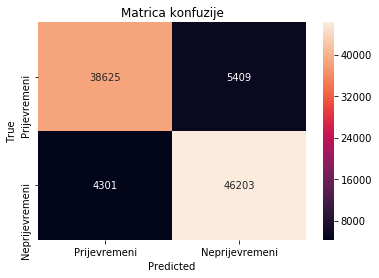

In [24]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

labels = ['Prijevremeni', 'Nisu prijevremeni']
tick_labels = ['Prijevremeni', 'Neprijevremeni']
cm = confusion_matrix(y_test, predictione, labels)
ax = sns.heatmap(cm, annot=True, fmt ='g', xticklabels = tick_labels, yticklabels = tick_labels ) 
ax.set_title("Matrica konfuzije")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')